# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Control Runs Here

In [2]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = False #True #False   #run waterfall analysis
run_t_ROI_Inten = False #True  #run  ROI intensity as a function of time
run_one_time = False   #run  one-time
run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
run_two_time = False #True #True #False    #run  two-time
run_four_time = False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

In [3]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True# #False   #run waterfall analysis
run_t_ROI_Inten = True# False #True  #run  ROI intensity as a function of time
run_one_time = True#False   #run  one-time
run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = True#False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name


## Make a directory for saving results

In [4]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [5]:
uid = '1a8df9' #count : 1 ['1a8df9'] (scan num: 10405) (Measurement: Au 10nm 20us 750Hz T=1 )
uid = 'b31e61'

uid ='f05d46'
uid = 'a84a73'

uid = '63ca1e'
uid ='ad4576'
uid = 'b27b2369'
uid = '5e0ffa04'

In [6]:
#start_time, stop_time = '2016-11-30  17:41:00', '2016-11-30  17:46:00'  
#sids, uids = find_uids(start_time, stop_time)

In [7]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/


# Don't Change these lines below here

* get metadata

In [8]:
md = get_meta_data( uid )

In [9]:
#md

* get data

In [10]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 200 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [11]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 5e0ffa04
number of images--> 200
uid--> 5e0ffa04-b8e9-4484-9421-c68095c07dce
scan_id--> 10437
start_time--> 2016-12-01 14:18:54
stop_time--> 2016-12-01 14:19:03
sample--> 50nm Au 2.5% PEG (X2)
Measurement--> sample X2 50nm Au in 2.5% PEG_visibility_series_#0
acquire period--> 0.01
exposure time--> 0.00134
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata if Wrong Input

In [12]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
acquisition_period = md['frame_time']   #acquisition time in sec
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image

#center = [ 2070-1381-0, 1475-4] 

In [13]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

In [14]:
print_dict( setup_pargs )

timeperframe--> 0.00135
lambda_--> 1.28481
path--> /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/
uid--> 5e0ffa04
dpix--> 0.0750000035623
exposuretime--> 2e-05
Ldet--> 4889.99986649
center--> [816, 1443]


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [15]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy'


<IPython.core.display.Javascript object>


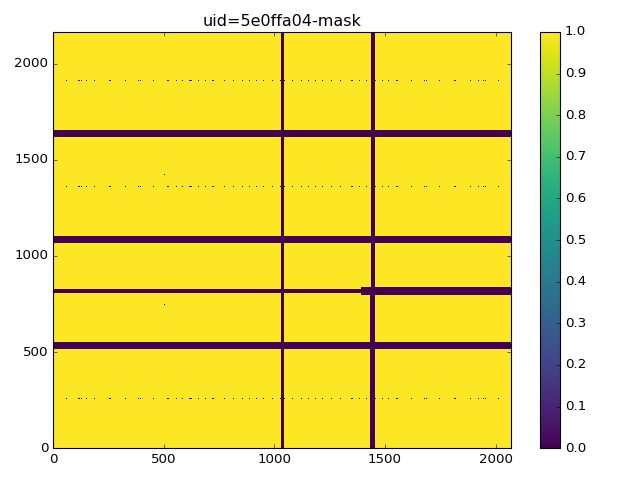

In [16]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = 'uid=%s-mask'%uid, reverse=True ) 
mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'uid=%s-mask'%uid, save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [17]:
img_choice_N = 10
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


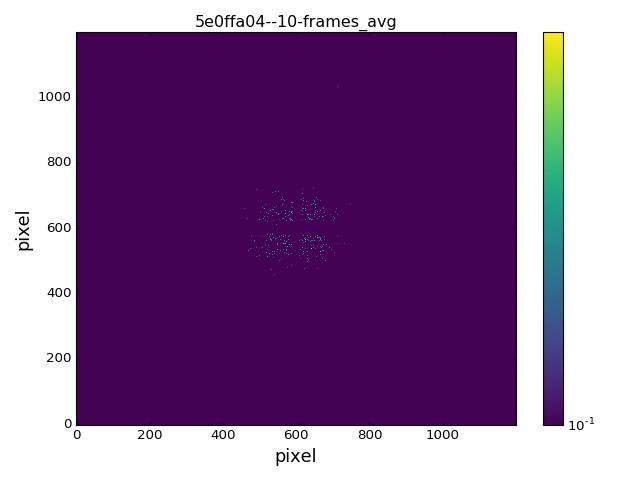

In [18]:
show_saxs_qmap( avg_img, setup_pargs, width=600, show_pixel = True,
               vmin=.1, vmax= np.max(avg_img), logs=True, image_name= uid + '--%s-frames_avg'%img_choice_N )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [19]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.0033807507875042637.
Will Always DO apply compress process.


In [20]:
good_start = 5  #make the good_start at least 0

Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_5e0ffa04-b8e9-4484-9421-c68095c07dce.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
It will create 2 temporary files for parallel compression.
hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
##
Bad frame list are: [0]
Combining the seperated compressed files together...
The good_start frame number is: 5 
5e0ffa04--fra-5-200


<IPython.core.display.Javascript object>


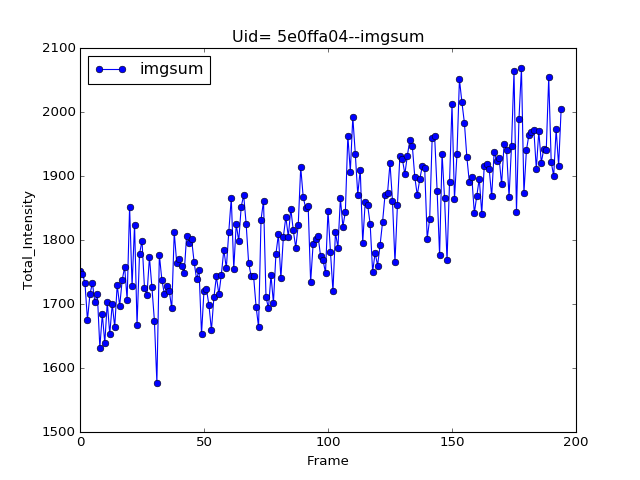

Total time: 0.12 min


In [21]:
t0= time.time()
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold= 1e14,
                        bins=1, num_sub= 100, num_max_para_process= 500  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs))
#FD = Multifile(filename, good_start, 100)
uid_ = uid + '--fra-%s-%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

run_time(t0)

In [22]:
#%system   free && sync && echo 3 > /proc/sys/vm/drop_caches && free

## Get bad frame list by a polynominal fit

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


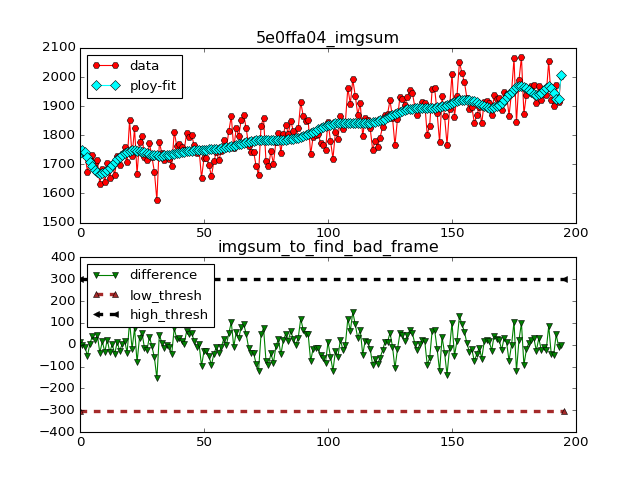

The bad frame list length is: 5


In [23]:
bad_frame_list =  get_bad_frame_list( imgsum, fit=True, plot=True,polyfit_order = 30, 
                        scale= 5.5,  good_start = good_start, uid=uid, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

#### For beamline to find the bad pixels

In [24]:
bp = find_bad_pixels( FD, bad_frame_list, md['uid'] )

In [25]:
#bp

In [26]:
bp.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

### Creat new mask by masking the bad pixels and get new avg_img

In [27]:
if False:
    mask = mask_exclude_badpixel( bp, mask, md['uid'])
    avg_img = get_avg_imgc( FD,  sampling = 1, bad_frame_list=bad_frame_list ) 

In [28]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename='uid=%s--img-sum-t'%uid, path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


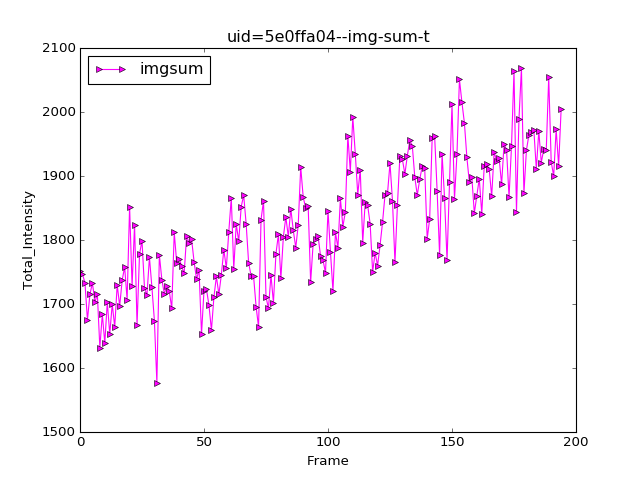

In [29]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

### Plot intensity average image

<IPython.core.display.Javascript object>


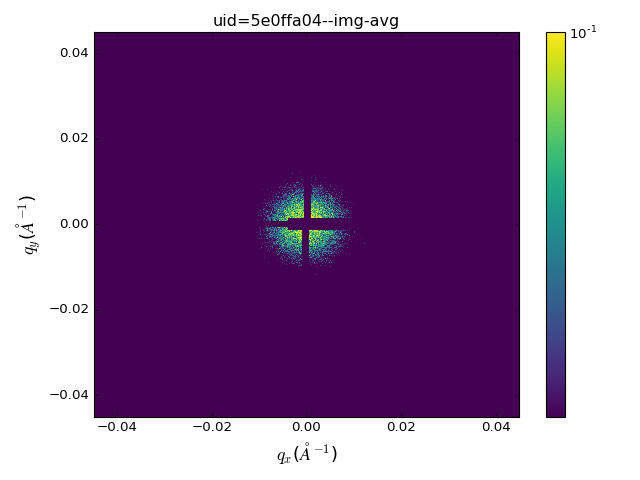

In [30]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= 'uid=%s--img-avg'%uid,  save=True) 
np.save(  data_dir + 'uid=%s--img-avg'%uid, avg_img)

## Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


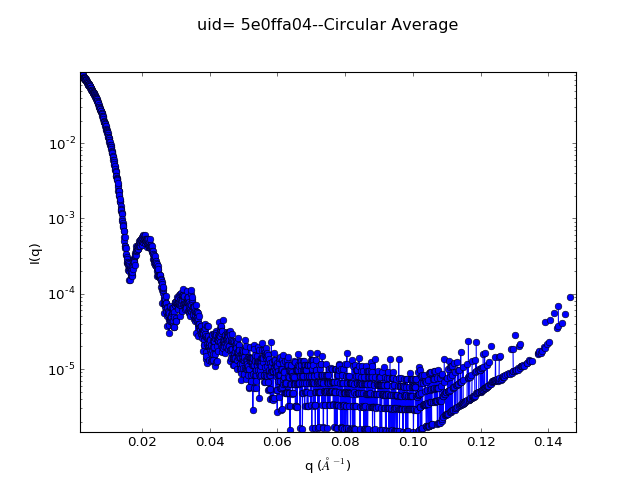

In [31]:
hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
plot_circular_average( qp, iq, q,  pargs=setup_pargs, 
                      xlim=[q.min(), q.max()], ylim = [iq.min(), iq.max()] )

In [32]:
pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
pd.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

In [33]:
mask =np.array( mask * hmask, dtype=bool) 
#show_img( mask )

# Fit Form Facotr

In [34]:
if run_fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [35]:
uniformq = True #False

### Define a non-uniform distributed rings by giving edges

In [36]:
if not uniformq:    
    width = 0.0002    
    number_rings= 1    
    qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  qcenters, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [37]:
if uniformq:    
    inner_radius= 0.005 #0.006  #16
    outer_radius = 0.04 #0.05  #112    
    num_rings = 12
    gap_ring_number = 6
    width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
    edges = None

In [38]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
q_ring_center = np.round( q_ring_center, 4)

<IPython.core.display.Javascript object>


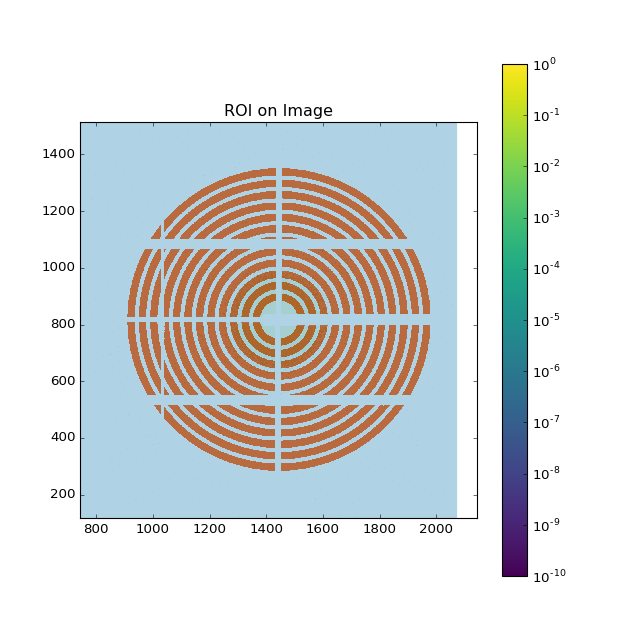

In [39]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uid, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 

<IPython.core.display.Javascript object>


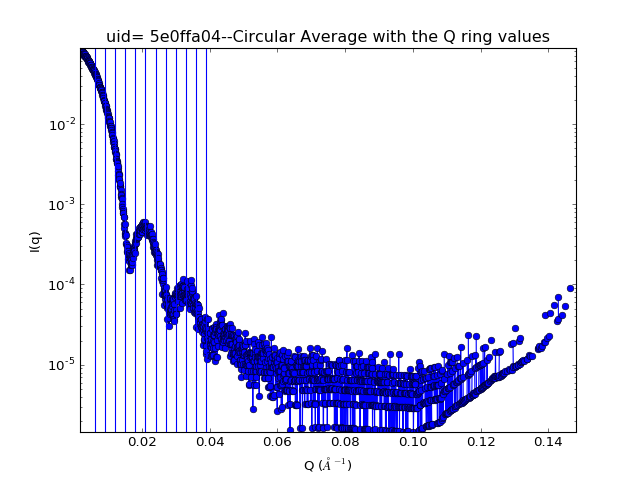

In [40]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[q.min(), q.max()],
                  ylim = [iq.min(), iq.max()],  save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


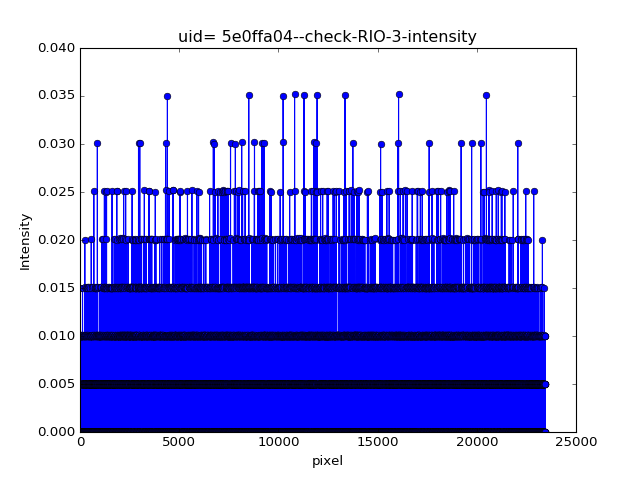

In [41]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= qth_interest, uid =uid, save=True, path=data_dir )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [42]:
Nimg = FD.end - FD.beg 
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
time_edge =  np.array( time_edge ) + good_start
print( time_edge )

[[  5   6]
 [102 103]
 [199 200]]


In [43]:
qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )

Averaging 397 images: 100%|██████████| 1/1 [00:00<00:00, 216.94it/s]


<IPython.core.display.Javascript object>


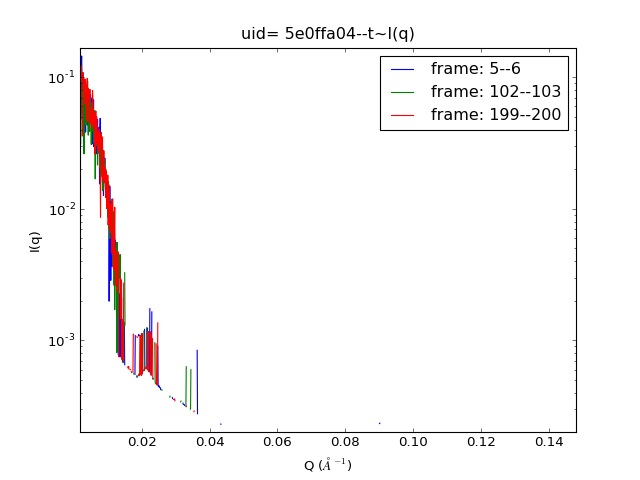

In [44]:
plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

## Do a waterfall analysis

In [45]:
if run_waterfall:
    qindex = qth_interest
    wat = cal_waterfallc( FD, ring_mask, qindex= qindex, save =True, path=data_dir, uid=uid)

Get waterfall for q index=3: 100%|██████████| 195/195 [00:00<00:00, 4379.62it/s]


<IPython.core.display.Javascript object>


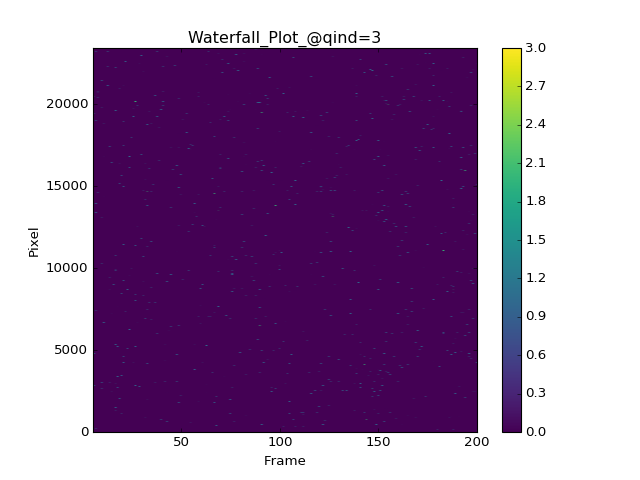

In [46]:
if run_waterfall: 
    plot_waterfallc( wat, qindex, aspect=None, 
                        vmax= np.max(wat), uid=uid, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 195/195 [00:00<00:00, 7515.91it/s]


<IPython.core.display.Javascript object>


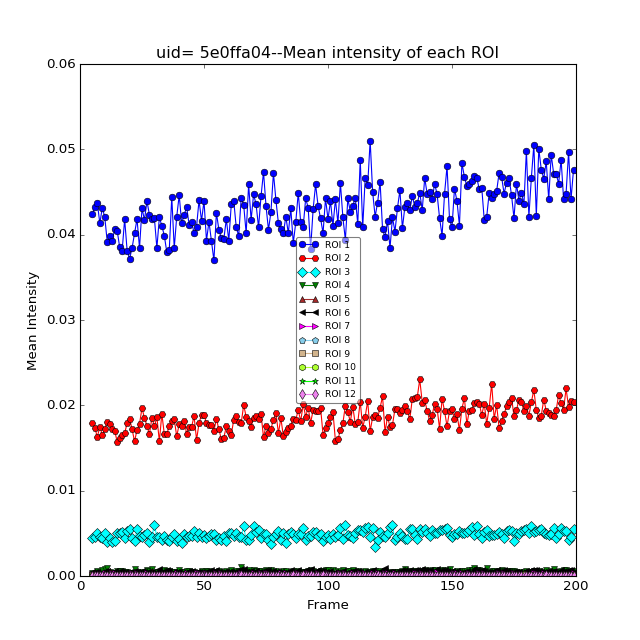

In [47]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, ring_mask, timeperframe = None,  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uid, save=True, path=data_dir )
    ring_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [48]:
define_good_series = False
if define_good_series:
    FD = Multifile(filename, beg = good_start, end = Nimg)
    uid_ = uid + '--fra-%s-%s'%(FD.beg, FD.end)
    print( uid_ )

In [49]:
lag_steps = None

In [50]:
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)
else:
    norm=None 
if use_imgsum_norm:
    imgsum_ = imgsum
else:
    imgsum_ = None     

In [51]:
bad_frame_list

array([0, 1, 2, 3, 4])

In [52]:
g2=[]
taus=[]          

if run_one_time: 
    t0 = time.time()    
    g2, lag_steps  = cal_g2p( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )
    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--6--
Bad frame involved and will be precessed!
196 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


 33%|███▎      | 4/12 [00:00<00:00, 22.08it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:03<00:00,  3.98it/s]

G2 calculation DONE!
Total time: 0.11 min


In [53]:
if run_one_time: 
    taus = lag_steps * timeperframe
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid_  ) 
    save_g2( g2, taus=taus, qr= q_ring_center, qz=None, uid=uid_, path= data_dir )

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/ with filename as uid=5e0ffa04--fra-5-200--g2.csv


### Plot the one time correlation functions

In [54]:
if run_one_time and not run_fit_g2:
    plot_g2( g2, res_pargs= res_pargs,  master_plot='qz',vlim=[0.95, 1.05], geometry='saxs', append_name=  ''  )    

# Fit g2

In [55]:
if run_one_time and  run_fit_g2:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2,  res_pargs=res_pargs, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fit = dict(taus=taus_fit, q_ring_center= q_ring_center,  
                         path=data_dir, uid=uid +'_fra-%s-%s'%(FD.beg, FD.end) +'_g2_fit'       )
    

In [56]:
if run_one_time and  run_fit_g2:
    dfv = save_g2_fit_para_tocsv(g2_fit_result, 
                    filename= 'uid=%s'%uid_  +'_g2_fit_paras', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/uid=5e0ffa04--fra-5-200_g2_fit_paras.csv


<IPython.core.display.Javascript object>


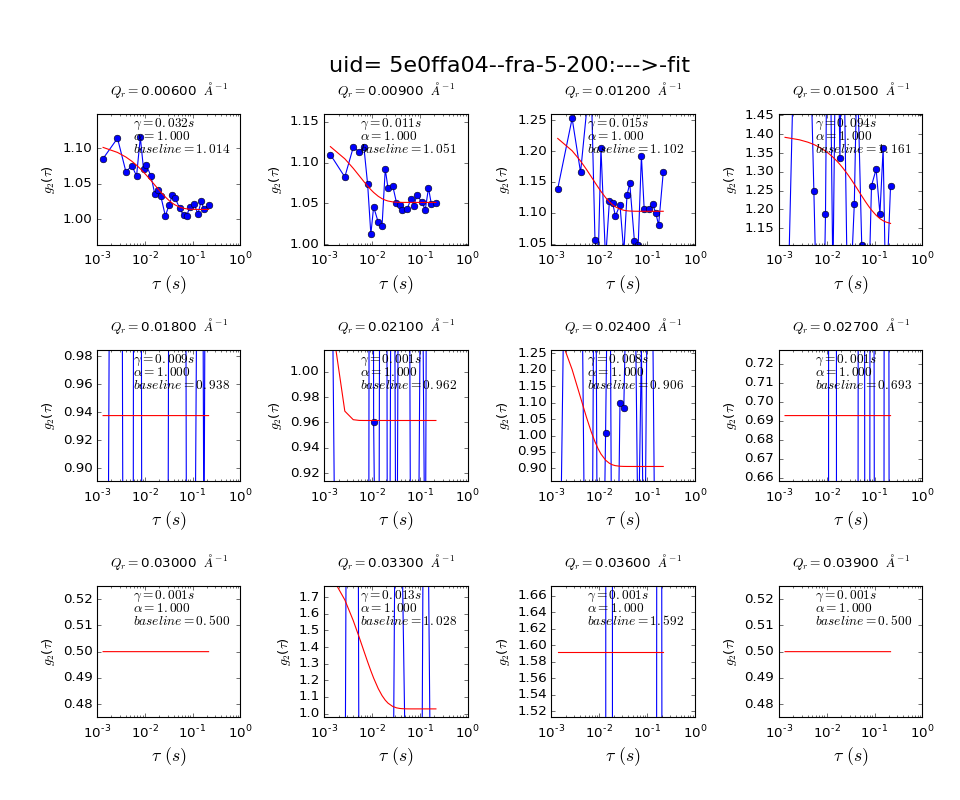

In [57]:
if run_one_time and  run_fit_g2:
    plot_g2( g2, res_pargs= res_pargs, tau_2 = taus_fit, g2_2 = g2_fit,  
        fit_res= g2_fit_result, function = 'stretched', master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name=  '-fit'  )

The fitted diffusion coefficient D0 is:  6.480e+05   A^2S-1


<IPython.core.display.Javascript object>


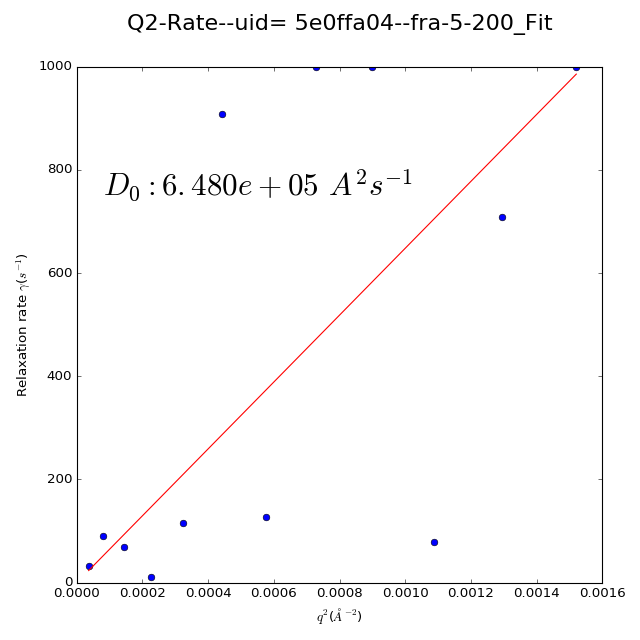

In [58]:
if run_one_time and  run_fit_g2:
    fit_q_rate(  q_ring_center[:],dfv['relaxation_rate'], power_variable= False, 
           uid=uid_  , path= data_dir )

# For two-time

In [59]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()

100%|██████████| 195/195 [00:00<00:00, 804.56it/s]


In [60]:
t0=time.time()
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )
run_time( t0 )        

100%|██████████| 12/12 [00:02<00:00,  3.83it/s]

Total time: 0.04 min


<IPython.core.display.Javascript object>


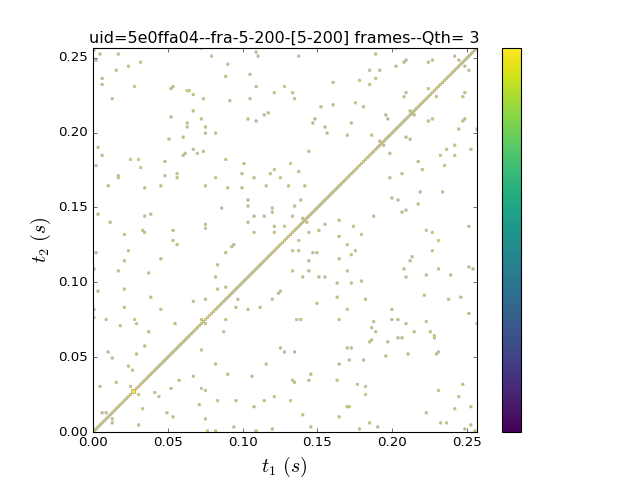

In [61]:
if run_two_time:
    show_C12(g12b, q_ind= qth_interest, N1= FD.beg, N2=min( FD.end,1000), vmin=1.1, vmax=1.25,
             timeperframe=timeperframe,save=True,
             path= data_dir, uid = uid_ )
    

In [62]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargsb = dict(taus=tausb, q_ring_center=q_ring_center,  path=data_dir, uid=uid_       )
    save_g2( g2b, taus=tausb, qr= q_ring_center, qz=None, uid=uid_ +'-fromTwotime', path= data_dir )
    #plot_saxs_g2( g2b, tausb,  vlim=[0.95, 1.05], res_pargs=res_pargsb) 

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/ with filename as uid=5e0ffa04--fra-5-200-fromTwotime--g2.csv


In [63]:
if run_two_time:
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit( g2b,  res_pargs=res_pargsb, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fitb = dict(taus=taus_fitb, q_ring_center= q_ring_center,  
                         path=data_dir, uid=uid_  +'_g2b_fit'       )
    
    dfvb = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= 'uid=%s'%uid_  + '_g2b_fit_paras', path=data_dir )

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/uid=5e0ffa04--fra-5-200_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


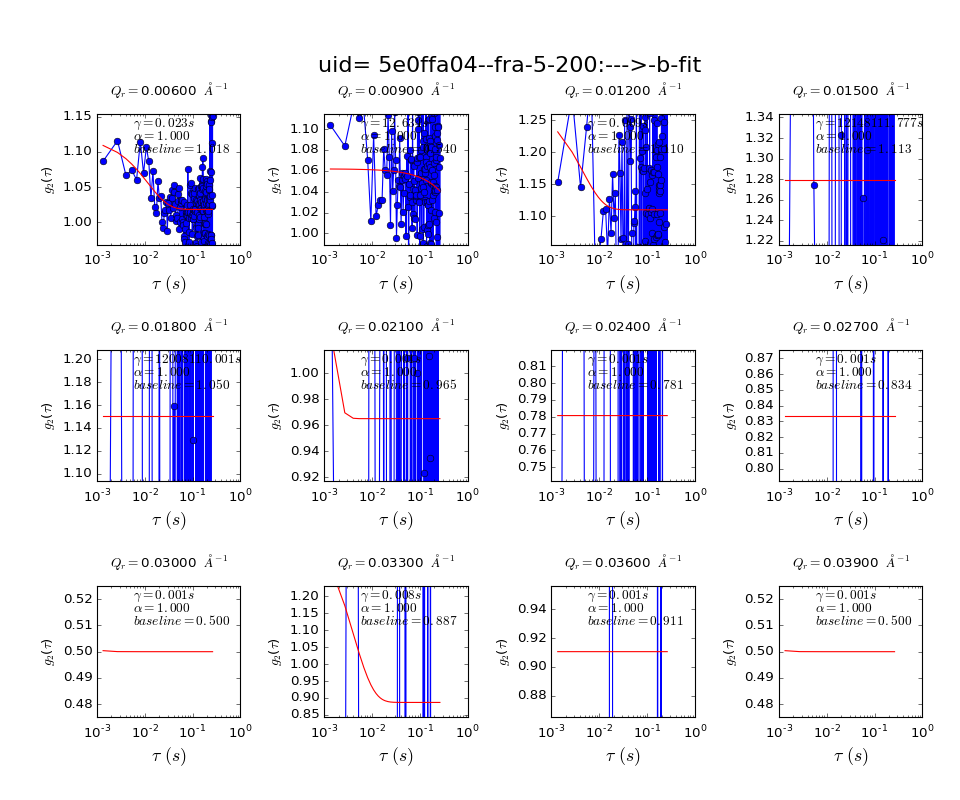

In [64]:
if run_two_time:
    plot_g2( g2b, res_pargs= res_pargsb, tau_2 = taus_fitb, g2_2 = g2_fitb,  
        fit_res= g2_fit_resultb, function = 'stretched', master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name= '-b-fit'  )

<IPython.core.display.Javascript object>


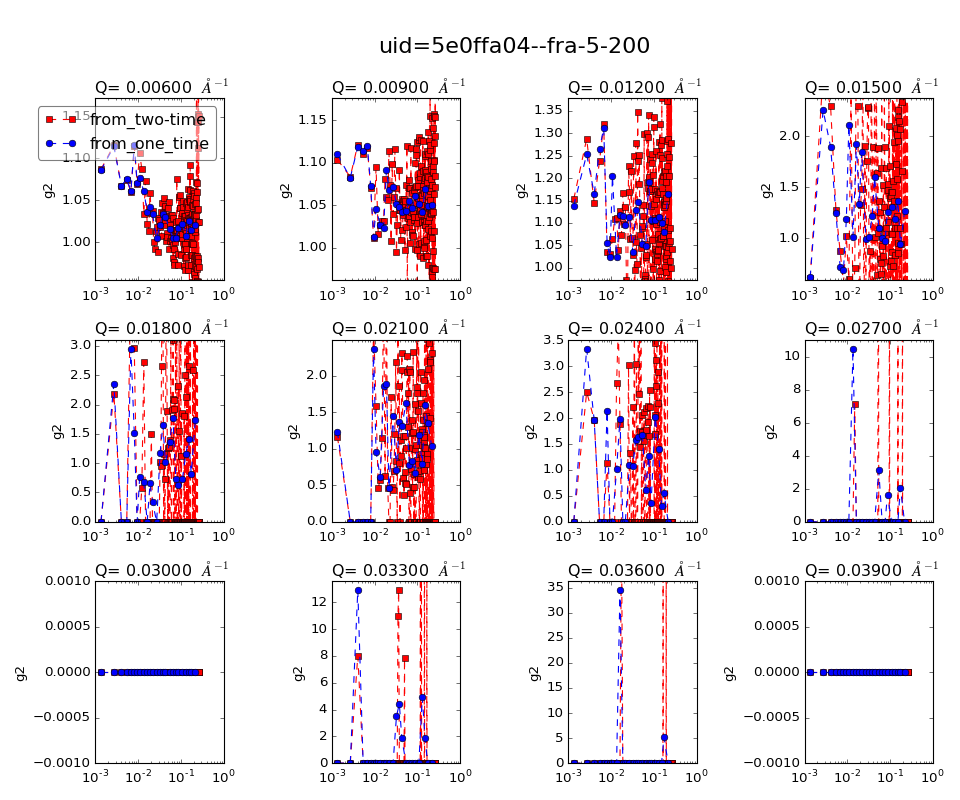

/opt/conda_envs/analysis/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [65]:
if run_two_time:
    #fit_q_rate(  q_ring_center[:],dfvb['relaxation_rate'], power_variable= False,  uid=uid +'-g2b' , path= data_dir )
    plot_saxs_two_g2( g2, taus, 
                 g2b, tausb, res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid_  )

# Four Time Correlation

In [66]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

Total time: 0.00 min


In [67]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir, uid=uid_      )
     
    save_saxs_g2(   g4,  res_pargs4, taus=taus4, filename= 'uid=%s'%uid_  + '--g4.csv' )             


The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5e0ffa04/ with filename as uid=5e0ffa04--fra-5-200--g4.csv


<IPython.core.display.Javascript object>


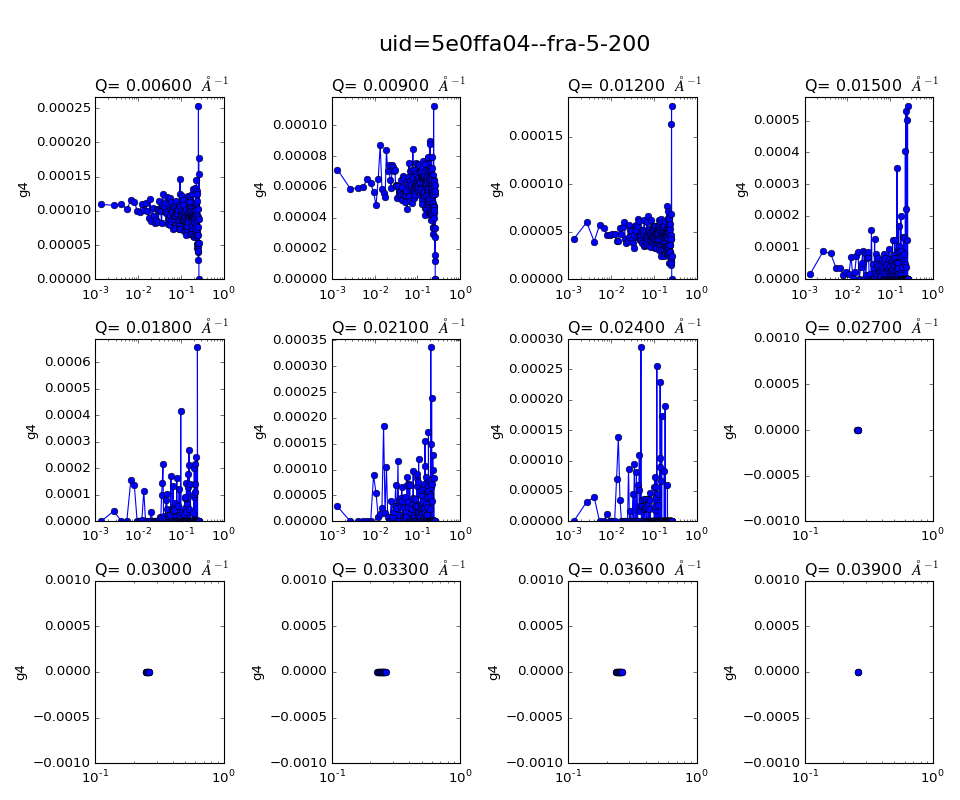

In [68]:
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4)  

# Speckel Visiblity

In [69]:
if run_xsvs:    
    max_cts = get_max_countc(FD, ring_mask )
    qind, pixelist = roi.extract_label_indices(   ring_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    num_times = len(time_steps)
    #times = time_steps * exposuretime    
    times = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * acquisition_period
    #print( 'The time steps are :%s'%time_steps )
    print( 'The max counts are: %s'%max_cts )
    #print( times )

Get max intensity of ROIs in all frames: 100%|██████████| 195/195 [00:00<00:00, 9548.65it/s]

The max counts are: 4


### Do historam 

In [70]:
if run_xsvs:
    if ring_avg == None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, ring_mask, timeperframe = None,  ) 
        ring_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std  =  xsvsp( FD, np.int_(ring_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [ring_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)

/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/kernel/__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app
  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:01<00:00,  5.18it/s]

Histogram calculation DONE!
Total time: 0.09 min


In [71]:
run_xsvs_all_lags = False
if run_xsvs_all_lags:
    times = exposuretime +  lag_steps * acquisition_period
    if data_pixel is None:
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data() 
if run_xsvs_all_lags:    
    t0=time.time()
    spec_bins, spec_his, spec_std, spec_kmean = get_binned_his_std(data_pixel, np.int_(ring_mask), lag_steps )
    run_time(t0)

In [72]:
if run_xsvs:
    save_arrays( spec_his, label= q_ring_center, filename = 'uid=%s--spec_his'%uid_, path=data_dir )
    save_arrays( spec_std, label= q_ring_center, filename = 'uid=%s--spec_std'%uid_, path=data_dir )
    np.save(  data_dir + 'uid=%s--spec_his'%uid_, spec_his)
    np.save(  data_dir + 'uid=%s--spec_std'%uid_, spec_std)
    np.save(  data_dir + 'uid=%s--K_mean'%uid_, spec_kmean)
    

### Do historam fit by negtive binominal function with maximum likehood method

In [73]:
if run_xsvs:
    qth= None
    #max_bins = 1
    hist_err = spec_std #None# spec_std #None
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std = hist_err, max_bins=2,
                         varyK= False, qth= qth, spec_bins= spec_bins, lag_steps=lag_steps, rois_lowthres= None)

In [74]:
if run_xsvs:
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   10 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

The difference sum of average photon counts between fit and data are: 0.0
##############################
The fitted M for Qth= 10 are: [0.002075955279892927, 0.0039313661104874217]
5.03393718725e-05
##############################


## Plot fit results

<IPython.core.display.Javascript object>


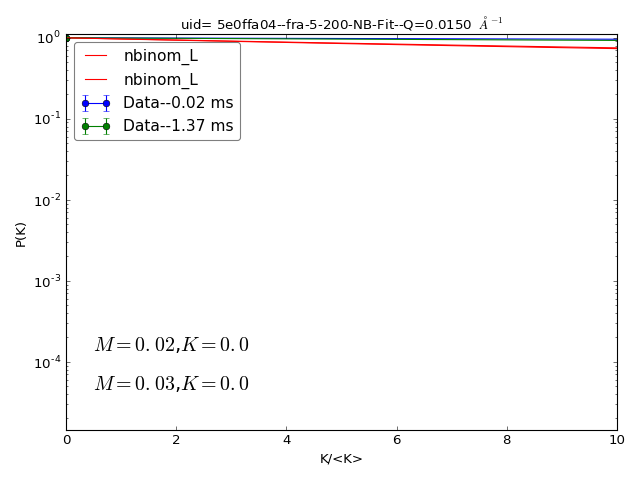

In [75]:
if run_xsvs:   
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times, q_ring_center=q_ring_center, path=data_dir)

In [76]:
if run_xsvs:    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times, q_ring_center=q_ring_center, path=data_dir )

<IPython.core.display.Javascript object>

### Get contrast

In [77]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    df = save_KM(  spec_kmean, KL_val, ML_val, qs=q_ring_center, uid=uid , path = data_dir )
    #print( df )

### Plot contrast with g2 restuls

In [78]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times, taus, q_ring_center, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

<IPython.core.display.Javascript object>

In [79]:
if run_xsvs:
    plot_g2_contrast( contrast_factorL, g2, times, taus, q_ring_center, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

<IPython.core.display.Javascript object>

# Creat PDF Report

In [80]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)

In [81]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['beg'] = FD.beg
md['end'] = FD.end
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'uid=%s-md.csv'%uid, 'w')

In [82]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=5e0ffa04_1.pdf
****************************************


In [83]:
#att_pdf_report = True

## Attach the PDF report to Olog 

In [84]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Analysis PDF Report and with the attachments


# The End!